"- https://www.rottentomatoes.com/top/bestofrt/?year=2020
- https://www.rottentomatoes.com/top/bestofrt/?year=2010
	- det er top 100 film fra et givent år

- Scrape navn, genre, runtime, tomatometer score og audience score på filmene fra årstallet 2020 og 1990
	- Hvis en film har flere genre så tilhører den alle de forskellige genre grupper

- Vis den gennemsnitlige audience score for hver genre i 2020 og 2010, i den samme barchart

- Find den genre hvor der er størst forskel fra audience score og tomatometer score i 2010
	- har det ændret sig i 2020?
	- hvis ja
		- vis en barchart af de forskellige genre

- Hvad er den gennemsnitlige runtime for genren 'drama' i 2010 og 2020?"

In [1]:
import bs4
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline 

def getSoup(url):
    r = requests.get(url)
    r.raise_for_status()
    return bs4.BeautifulSoup(r.text, 'html.parser')

baseurl = 'https://www.rottentomatoes.com'

def get_meta_data(_url):
    url = baseurl + _url
    print("Fetching metadata from " + url)
    soup = getSoup(url)
    #print(soup.find('score-board', {'class': 'scoreboard'}).get('audiencescore'))
    audience_score = int(soup.find('score-board', {'class': 'scoreboard'}).get('audiencescore'))
    year, genre, runtime_str = soup.find('p', {'class': 'scoreboard__info'}).text.split(",")
    runtime = re.sub("[^0-9 ]", "", runtime_str).strip().split(" ")
    runtime = int(runtime[0])*60 + int(runtime[1])
    return audience_score, genre.strip(), runtime

def get_top_movies(year):
    url = baseurl + '/top/bestofrt/?year=' + str(year)
    soup = getSoup(url)
    rows = soup.find_all('tr')
    movies = []
    exception_count = 0
    for idx, row in enumerate(rows):
        try:
            rank = int(row.find('td', {'class': 'bold'}).text.replace('.','').strip())
            score = int(row.find('span', {'class': 'tMeterScore'}).text.replace('%','').strip())
            titlesplit = row.find('a', {'class': 'articleLink'}).text.split("(")
            name = titlesplit[0].strip() 
            if len(titlesplit) == 3: name += "(" + titlesplit[1] 
            year = int(titlesplit[-1].replace(")","").strip())
            url = str(row.find('a', {'class': 'articleLink'}).get('href')).strip()
            audience_score, genre, runtime = get_meta_data(url)
            movies.append({"rank":rank, "score":score, "audience score":audience_score, "name":name, "year":year, "genre":genre, "runtime (min.)":runtime})
        except Exception as e:
            exception_count += 1
            print('Exception #', exception_count,'in row #', idx,': ', e)
            continue
    return movies

print("Building movie dataframes...\n")
movies_2020 = get_top_movies(2020)
movies_2010 = get_top_movies(2010)
df_movies_2020 = pd.DataFrame.from_dict(movies_2020)
df_movies_2010 = pd.DataFrame.from_dict(movies_2010)
print("\nDone.")
print("Sucessfully build dataframes with ", len(movies_2020), "+",len(movies_2010), "movies")


Building movie dataframes...

Exception # 1 in row # 0 :  'NoneType' object has no attribute 'text'
Exception # 2 in row # 1 :  'NoneType' object has no attribute 'text'
Exception # 3 in row # 2 :  'NoneType' object has no attribute 'text'
Exception # 4 in row # 3 :  'NoneType' object has no attribute 'text'
Exception # 5 in row # 4 :  'NoneType' object has no attribute 'text'
Exception # 6 in row # 5 :  'NoneType' object has no attribute 'text'
Exception # 7 in row # 6 :  'NoneType' object has no attribute 'text'
Exception # 8 in row # 7 :  'NoneType' object has no attribute 'text'
Exception # 9 in row # 8 :  'NoneType' object has no attribute 'text'
Exception # 10 in row # 9 :  'NoneType' object has no attribute 'text'
Exception # 11 in row # 10 :  'NoneType' object has no attribute 'text'
Exception # 12 in row # 11 :  'NoneType' object has no attribute 'text'
Exception # 13 in row # 12 :  'NoneType' object has no attribute 'text'
Exception # 14 in row # 13 :  'NoneType' object has n

In [10]:
#print(df_movies_2020)
print("top 5 movies 2020")
df_movies_2020.head()
print("top 5 movies 2010")
df_movies_2010.head()

top 5 movies 2020
top 5 movies 2010


,rank,score,audience score,name,year,genre,runtime (min.)
0,1,98,90,Toy Story 3,2010,Fantasy/Animation,102
1,2,96,87,The Social Network,2010,Drama/Biography,120
2,3,99,91,How to Train Your Dragon,2010,Fantasy/Animation,98
3,4,95,85,True Grit,2010,Drama/Western,110
4,5,94,92,The King's Speech,2010,Drama/History,118


In [3]:
def get_aud_score_avg_genre(df):
    aud_score = df['audience score']
    genres = df['genre']
    genre_scores = {}
    genre_count = {}
    avg_genre_scores = {}
    
    for idx, genre in enumerate(genres.values):
            genres = genre.split('/')
            for g in genres:
                if g in genre_scores:
                    genre_scores[g] += float(aud_score.loc[idx])
                else:
                    genre_scores[g] = float(aud_score.loc[idx])
                if g in genre_count: 
                    genre_count[g] += 1.0
                else: 
                    genre_count[g] = 1.0

    for g in genre_scores:
        score = genre_scores[g]
        avg_genre_scores[g] = round(float(score)/float(genre_count[g])) 
    return avg_genre_scores

avg_genre_scores_2020 = get_aud_score_avg_genre(df_movies_2020)
avg_genre_scores_2010 = get_aud_score_avg_genre(df_movies_2010)

df_avg_genre_scores = pd.DataFrame({'2020':pd.Series(avg_genre_scores_2020), '2010':pd.Series(avg_genre_scores_2010)})
df_avg_genre_scores = df_avg_genre_scores.fillna(0.0)
df_avg_genre_scores = df_avg_genre_scores.replace(np.nan,0)
display(df_avg_genre_scores)

,2020,2010
Action,74.0,75.0
Adventure,92.0,79.0
Animation,88.0,82.0
Biography,84.0,80.0
Comedy,72.0,69.0
Crime,0.0,86.0
Documentary,80.0,83.0
Drama,73.0,74.0
Fantasy,84.0,85.0
History,91.0,92.0


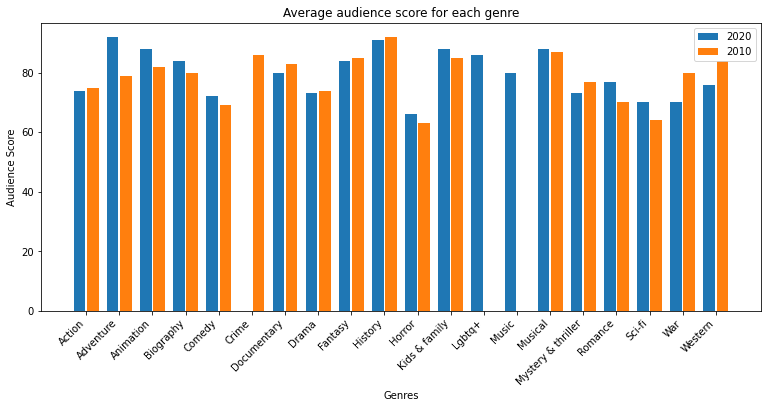

In [4]:
def get_genres(df):
    genres = df['genre']
    unique_genres = []
    for gs in genres:
        genrelist = gs.split('/')
        for g in genrelist:
            if g not in unique_genres:
                unique_genres.append(g)
    return unique_genres

def get_column_as_list(df, column):
    return df[column].tolist()

list_2020 = get_column_as_list(df_avg_genre_scores, '2020')
list_2010 = get_column_as_list(df_avg_genre_scores, '2010')

genres = get_genres(df_movies_2020)
x = df_avg_genre_scores.index.tolist()
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light')
x_axis = np.arange(len(list_2020))
plt.bar(x_axis - 0.2, list_2020, 0.35, label = '2020')
plt.bar(x_axis + 0.2, list_2010, 0.35, label = '2010')
plt.xticks(x_axis, x)
plt.xlabel("Genres")
plt.ylabel("Audience Score")
plt.title("Average audience score for each genre")
plt.legend()
plt.show()

In [7]:
def find_max_score_diff(df):
    filtered_df = df.query("'score' > 0 and 'audience score' > 0")
    return np.argmax(filtered_df['score']-filtered_df['audience score'])

max_score_diff_2020 = find_max_score_diff(df_movies_2020)
max_score_diff_2010 = find_max_score_diff(df_movies_2010)
print("2020:", max_score_diff_2020)
df_movies_2020[[max_score_diff_2020]]
print("2010:", max_score_diff_2010)
df_movies_2010[[max_score_diff_2010]]

TypeError: data type "score" not understood